In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras  # Фреймворк для нейронных сетей
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential  # Последовательная модель
from tensorflow.keras.layers import Dense, Dropout  # Полносвязные слои и слой dropout

warnings.filterwarnings("ignore", category=UserWarning, module='google.protobuf')

# Установка случайных seed для воспроизводимости результатов
np.random.seed(0)  # Фиксируем seed для numpy
tf.random.set_seed(1)  # Фиксируем seed для TensorFlow

In [2]:
data = {
    "Предложение": [
        "Аак", 
        "Аак аак", 
        "Бип", 
        "Бип бип", 
        "Аак бип", 
        "Аак аак бип", 
        "Бип аак бип", 
        "Бип аак бип аак"
    ],
    "Aaк": [1, 2, 0, 0, 1, 2, 1, 2],
    "Бип": [0, 0, 1, 2, 1, 1, 2, 2],
    "Настроение": [
        "Грустный", 
        "Грустный", 
        "Грустный", 
        "Грустный", 
        "Радостный", 
        "Радостный", 
        "Радостный", 
        "Радостный"
    ]
}

df = pd.DataFrame(data)
df

,Предложение,Aaк,Бип,Настроение
0,Аак,1,0,Грустный
1,Аак аак,2,0,Грустный
2,Бип,0,1,Грустный
3,Бип бип,0,2,Грустный
4,Аак бип,1,1,Радостный
5,Аак аак бип,2,1,Радостный
6,Бип аак бип,1,2,Радостный
7,Бип аак бип аак,2,2,Радостный


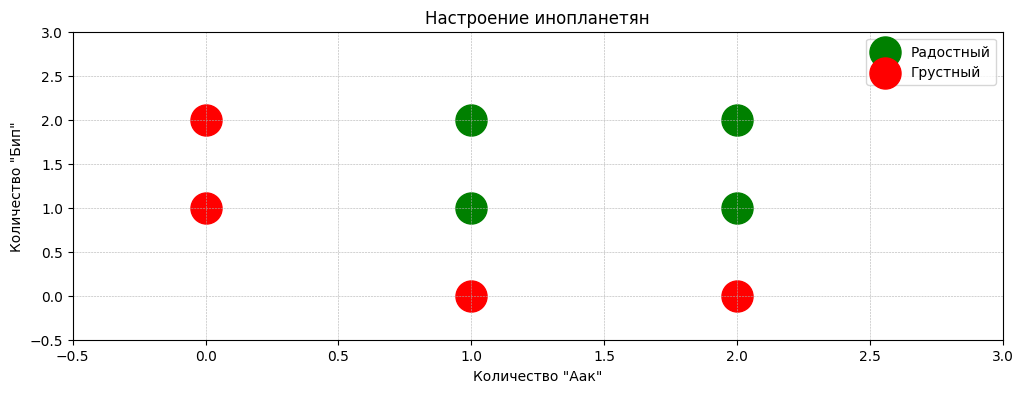

In [3]:
# Создаем фигуру
figsize=(12, 4)
xlim=(-0.5, 3)
ylim=(-0.5, 3)

plt.figure(figsize=figsize)

# Разделяем данные по настроению
happy = df[df['Настроение'] == 'Радостный']
sad = df[df['Настроение'] == 'Грустный']

# Рисуем точки
plt.scatter(happy['Aaк'], happy['Бип'], c='green', label='Радостный', s=500)
plt.scatter(sad['Aaк'], sad['Бип'], c='red', label='Грустный', s=500)

# Настраиваем оси и заголовок
plt.xlabel('Количество "Аак"')
plt.ylabel('Количество "Бип"')
plt.title('Настроение инопланетян')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.4)
plt.show()

In [4]:
# Функция для визуализации границы принятия решений
def plot_function(f):
    #plt.figure(figsize=figsize)

    # Вспомогательная функция для преобразования выхода в бинарный класс
    def h(x, y):
        return f(x, y) >= 0.5  # порог 0.5 для бинарной классификации

    # Создаем сетку точек для построения границы
    xx, yy = np.meshgrid(np.arange(xlim[0], xlim[1], 0.005),
                         np.arange(ylim[0], ylim[1], 0.005))

    # Вычисляем предсказания для каждой точки сетки
    Z = np.array([h(i[0], i[1]) for i in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    # 1. Сначала рисуем заливку областей (zorder=1)
    plt.contourf(xx, yy, Z, colors=['red', 'green'], alpha=0.25,
                 levels=range(-1, 2), zorder=1)

    # 2. Затем рисуем границу между областями (zorder=2)
    plt.contour(xx, yy, Z, colors='k', linewidths=3, zorder=2)

    # 3. Рисуем точки поверх всего (zorder=3) с черной границей
    plt.scatter(happy['Aaк'], happy['Бип'], c='green', edgecolor='black',
                linewidth=2, label='Радостный', s=300, zorder=3)

    plt.scatter(sad['Aaк'], sad['Бип'], c='red', edgecolor='black',
                linewidth=2, label='Грустный', s=300, zorder=3)

    # Настраиваем оси и заголовок
    plt.xlabel('Количество "Аак"')
    plt.ylabel('Количество "Бип"')
    plt.title('Настроение инопланетян')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.4, zorder=0)
    #plt.show()


# Функция активации - ступенчатая функция (персептрон)
def step(x):
    if x >= 0:
        return 1  # активация при положительном входе
    else:
        return 0  # нет активации при отрицательном входе


# Первый линейный классификатор (нейрон первого слоя)
def line_1(a, b):
    return step(6 * a + 10 * b - 15)  # веса: 6 и 10, смещение -15


# Второй линейный классификатор (нейрон первого слоя)
def line_2(a, b):
    return step(10 * a + 6 * b - 15)  # веса: 10 и 6, смещение -15


# Функция смещения (bias)
def bias(a, b):
    return 1  # всегда возвращает 1 (аналог единичного нейрона)


# Нейронная сеть с ступенчатой функцией активации (двухслойная)
def nn_with_step(a, b):
    # Комбинируем выходы первого слоя с весами 1 и 1, и смещением -1.5
    return step(step(6 * a + 10 * b - 15) + step(10 * a + 6 * b - 15) - 1.5)


# Сигмоидная функция активации
def sigmoid(x):
    return np.exp(x) / (1.0 + np.exp(x))  # классическая сигмоида


# Нейронная сеть с сигмоидной функцией активации (двухслойная)
def nn_with_sigmoid(a, b):
    # Комбинируем выходы первого слоя с весами 1.0 и 1.0, и смещением -1.5
    return sigmoid(1.0 * sigmoid(6 * a + 10 * b - 15) + 1.0 * sigmoid(10 * a + 6 * b - 15) - 1.5)

# Визуализация границ первого слоя (линейные классификаторы и смещение)

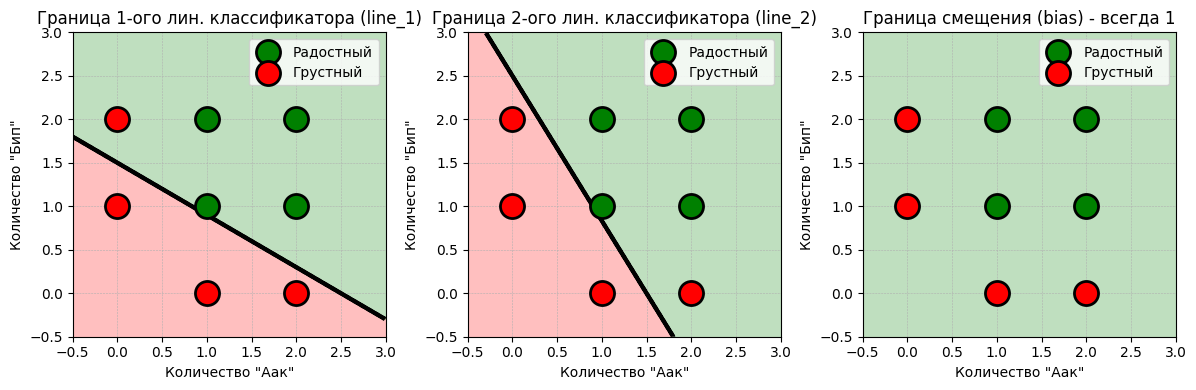

In [5]:
# Создаем фигуру с 1 строкой и 3 столбцами для первых трех графиков
plt.figure(figsize=figsize)

# Первый график - line_1
plt.subplot(1, 3, 1)
plot_function(line_1)
plt.title("Граница 1-ого лин. классификатора (line_1)")

# Второй график - line_2
plt.subplot(1, 3, 2)
plot_function(line_2)
plt.title("Граница 2-ого лин. классификатора (line_2)")

# Третий график - bias
plt.subplot(1, 3, 3)
plot_function(bias)
plt.title("Граница смещения (bias) - всегда 1")

plt.tight_layout()
plt.show()

# Визуализация границ второго слоя (нелинейные классификаторы)

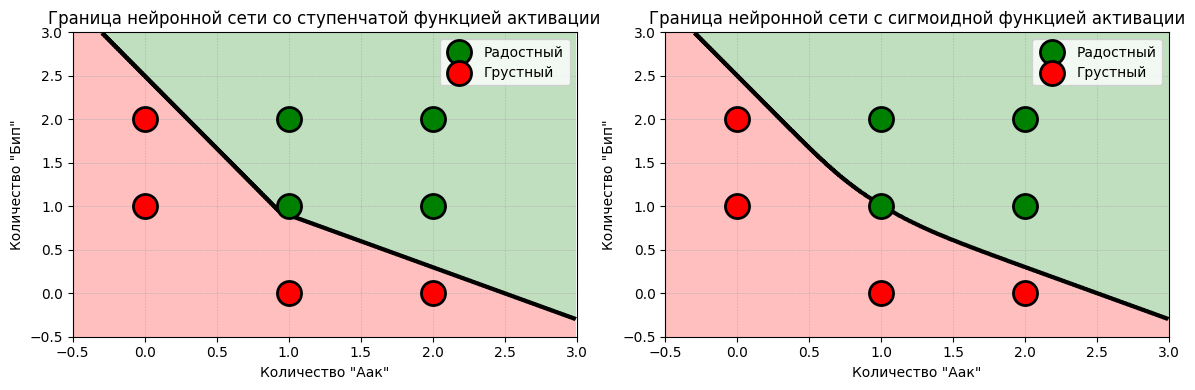

In [6]:
# Создаем фигуру с 1 строкой и 2 столбцами для следующих двух графиков
plt.figure(figsize=figsize)

# Первый график - nn_with_step
plt.subplot(1, 2, 1)
plot_function(nn_with_step)
plt.title("Граница нейронной сети со ступенчатой функцией активации")

# Второй график - nn_with_sigmoid
plt.subplot(1, 2, 2)
plot_function(nn_with_sigmoid)
plt.title("Граница нейронной сети с сигмоидной функцией активации")

plt.tight_layout()
plt.show()

# Графический пример классификации точек на плоскости с использованием нейронной сети

## Загрузка датасета

In [7]:
# Загружаем датасет 'one_circle.csv' (один круг)
df = pd.read_csv('data/one_circle.csv', index_col=0)  # Читаем CSV-файл, первый столбец - индекс

x = np.array(df[['x_1', 'x_2']])  # Извлекаем признаки x_1 и x_2 в numpy массив
y = np.array(df['y']).astype(int)  # Извлекаем метки классов и преобразуем в целые числа

df

,x_1,x_2,y
0,-0.759416,2.753240,0
1,-1.885278,1.629527,0
2,2.463302,-1.023869,0
3,-1.986004,-0.898810,0
4,2.010834,-2.580117,0
...,...,...,...
105,-1.376637,2.778703,1
106,-0.703722,0.215382,1
107,0.729767,-2.479655,1
108,-1.715920,-0.393404,1


## Визуализация данных

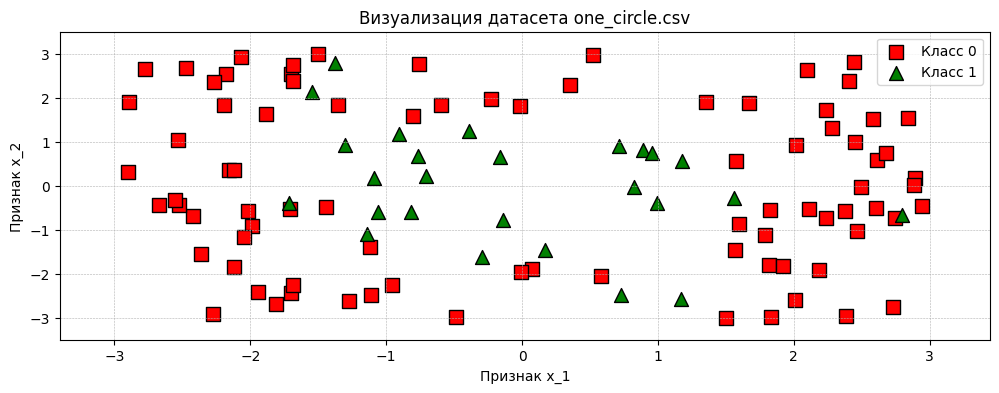

In [8]:
# Настройки графика
xlim = (df['x_1'].min() - 0.5, df['x_1'].max() + 0.5)
ylim = (df['x_2'].min() - 0.5, df['x_2'].max() + 0.5)

plt.figure(figsize=figsize)

# Разделяем данные по классам
class_0 = df[df['y'] == 0]
class_1 = df[df['y'] == 1]

# Рисуем точки
plt.scatter(class_0['x_1'], class_0['x_2'], c='red', marker='s', label='Класс 0', s=100, ec='black')
plt.scatter(class_1['x_1'], class_1['x_2'], c='green', marker='^', label='Класс 1', s=100, ec='black')

# Настраиваем оси и заголовок
plt.xlabel('Признак x_1')
plt.ylabel('Признак x_2')
plt.title('Визуализация датасета one_circle.csv')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.4)

plt.show()

# Предварительная обработка данных

In [9]:
# Преобразуем метки классов в one-hot encoding (категориальный формат)
categorized_y = np.array(to_categorical(y, 2))  # Преобразуем y в one-hot векторы (2 класса)

## Создание и компиляция нейронной сети

In [10]:
# Строим модель нейронной сети
model = Sequential()  # Создаем последовательную модель

# Добавляем слои:
# 1. Полносвязный слой с 128 нейронами, активация ReLU, входная размерность 2 (x_1 и x_2)
model.add(Dense(128, activation='relu', input_shape=(2,)))

# 2. Слой Dropout с вероятностью 20% (для предотвращения переобучения)
model.add(Dropout(.2))

# 3. Полносвязный слой с 64 нейронами и активацией ReLU
model.add(Dense(64, activation='relu'))

# 4. Еще один слой Dropout с вероятностью 20%
model.add(Dropout(.2))

# 5. Выходной слой с 2 нейронами (по числу классов) и активацией softmax (для вероятностей классов)
model.add(Dense(2, activation='softmax'))

# Компилируем модель:
# - Функция потерь: категориальная кросс-энтропия (для многоклассовой классификации)
# - Оптимизатор: adam (адаптивный метод градиентного спуска)
# - Метрика: точность (accuracy)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Выводим информацию о модели
model.summary()  # Показывает архитектуру сети и количество параметров

C:\Users\novos\Desktop\GitHub\grokking-machine-learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,770 (34.26 KB)

 Trainable params: 8,770 (34.26 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Обучение нейронной сети
# Обучаем модель на данных:
# - x: признаки
# - categorized_y: метки в one-hot формате
# - epochs: 200 эпох (проходов по всему датасету)
# - batch_size: 10 (размер мини-пакета для градиентного спуска)
model.fit(x, categorized_y, epochs=200, batch_size=10, verbose=0)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


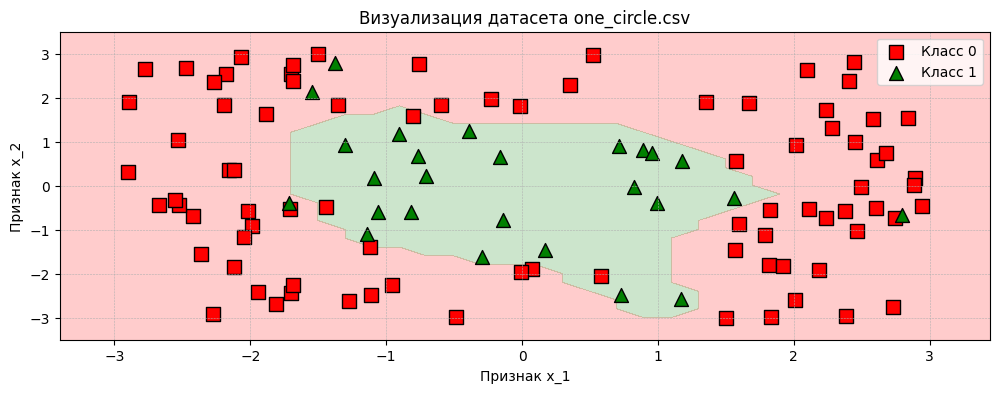

In [12]:
# Функция g(Z) преобразует предсказания модели в метки классов (0 или 1)
def g(Z):
    # Лямбда-функция f: возвращает 1, если второй элемент > первого, иначе 0
    f = lambda x: int(x[1] > x[0])
    # Применяем f к каждому элементу массива Z и возвращаем массив меток
    return np.array([f(i) for i in Z])


# Шаг сетки для построения границы решения
plot_step = 0.2

# Определяем границы графика по данным:
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1

# Создаем фигуру
plt.figure(figsize=figsize)

# Создаем сетку точек для визуализации границы решения:
# xx и yy — координаты всех точек на сетке
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step),  # Диапазон по оси X
    np.arange(y_min, y_max, plot_step)   # Диапазон по оси Y
)

# Получаем предсказания модели для всех точек сетки:
# Преобразуем сетку в массив точек (np.c_ объединяет координаты)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])  # возвращает вероятности классов (one-hot)

# Функция g(Z) преобразует вероятности в метки (0 или 1)
Z = g(Z).reshape(xx.shape)  # возвращает массив в форме сетки

# Заливаем области графика цветами в зависимости от предсказанного класса:
plt.contourf(xx, yy, Z, 
             colors=['red', 'green'],  # цвета для классов 0 и 1
             alpha=0.2,  # прозрачность заливки
             levels=range(-1, 2))  # уровни для контуров (чтобы разделить два класса)

# Рисуем точки данных:
# class_0 — точки класса 0 (красные квадраты)
plt.scatter(
    class_0['x_1'], class_0['x_2'],  # Координаты X и Y
    c='red', marker='s',             # Цвет и форма маркера
    label='Класс 0', s=100,          # Подпись и размер маркера
    ec='black'                       # Цвет границы маркера
)

# class_1 — точки класса 1 (зеленые треугольники)
plt.scatter(
    class_1['x_1'], class_1['x_2'],
    c='green', marker='^',
    label='Класс 1', s=100,
    ec='black'
)

plt.xlabel('Признак x_1')  # Подпись оси X
plt.ylabel('Признак x_2')  # Подпись оси Y
plt.title('Визуализация датасета one_circle.csv')  # Заголовок
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.4)
plt.show()